# 1. Deploy trained model

When we completed training "Mongolian Gers Detection Model" based on the Convolutional Neural Network framework, we saved it in the shared directory of the High-Performance Computing Cluster (HPC).<br>
We have worked on the HPC environment, from the training model to applying the trained model to newly obtained satellite images.


## 1.1 Load deep learning modules and verify the deep learning environment.

In [64]:
%%time
import scipy as sp
import numpy as np
import pandas as pd
import arcgis
from arcgis.learn import SingleShotDetector, prepare_data
import fastai
import torch
import torchvision
from matplotlib import pyplot as plt

print("arcgis API version =", arcgis.__version__)
print("fastai version =", fastai.__version__)
print("torch version =", torch.__version__)
print("torchvision version =", torchvision.__version__)

arcgis API version = 1.8.5
fastai version = 1.0.60
torch version = 1.4.0
torchvision version = 0.5.0
CPU times: user 2.76 ms, sys: 0 ns, total: 2.76 ms
Wall time: 4.1 ms


## 1.2 Checking if 'CUDA' device is picked up for training a model on GPU

In [65]:
torch.cuda.is_available()
torch.zeros((3, 224, 224)).cuda()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

## 1.3 Load image processing packages
#### Import image processing packages to visualize our detected results.  

In [66]:
from arcgis.learn._image_utils import _draw_predictions
import cv2
from arcgis.learn._utils.common import read_image
import PIL
import os
import datetime

## 1.4 Import saved trained model called "mongolian_ger_detecting_model.emd" 

In [67]:
ssd = SingleShotDetector.from_model(r'/scratch/username/workdir/Training_Output/models/mongolian_ger_detecting_model.emd')

## 1.5 Using "os" module in python, we could list up all the "tiff" files in the working directory. 
#### TIFF is a Tag Image File Format that stores raster graphics and image information, and our input satellite images are saved in TIFF format. 


In [ ]:
ger_district = ['ail100', 'amgalan', 'bayankhoshuu','MNB', 'nisekh','tolgoit','ub11','ub6','ub9']
non_ger_district = ['baruun4zam','bukhiinurguu','misheel','mongolgazar','urgakhnaran']
ger_district_dict = {}
non_ger_district_dict = {}


for f in os.listdir('one_mile_maps'):
    suffix = "clip.tif"
    if ((f.endswith(suffix) == True) & (f.split('_')[0] in ger_district)):
        ger_district_dict[f[:-4]] = ("{}/{}/{}".format(os.getcwd(),'one_mile_maps',f))
    elif ((f.endswith(suffix) == True) & (f.split('_')[0] in non_ger_district)):
        non_ger_district_dict[f[:-4]] = ("{}/{}/{}".format(os.getcwd(),'one_mile_maps',f))

ger_district_dict
non_ger_district_dict

## 1.6 Test prediction 
- Input: satellite images
- treshold = The probability above which a detection will be considered valid
- nms_overlap = the intersection over union threshold with other predicted bounding boxes, above which the box with the highest score will be considered a true positive. 
- Returns: A list of predicted bounding boxes on the given image [xmin, ymin, width, height].



In [ ]:
test_image = list(ger_district_dict.values())[0]
test_detection = ssd.predict(test_image, threshold=0.26, nms_overlap=0.12, return_scores=True, visualize=False, resize=False)

## 1.7 Vizualization with a list of bounding boxes and original images.  

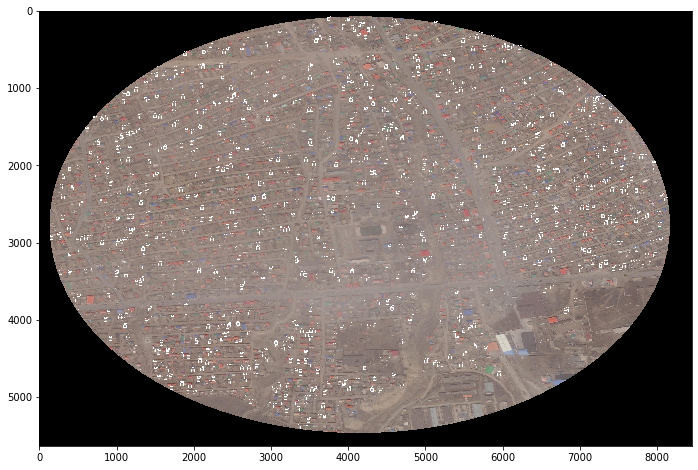

In [70]:
original_image = cv2.imread(test_image)
image_arr = _draw_predictions(original_image, test_detection[0], [str(round(i,2))for i in test_detection[2]])
image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,8))
plt.imshow(image_arr, interpolation='nearest')

## 1.8 Applying "Mongolian Ger Detection Model" to every satellite image stored in the working directory.

1.	Predict coordinates of bounding boxes for each input satellite image using "ssd.predict()" 
2.	Dropping duplicated boxes by calculating the pairwise distance between detected bounding boxes.
3.	Store the number of boxes and duplicates by the input variable names specified above. 
4.	Export the result in a "csv" format. 


In [120]:
%%time
gers = {}
BASE_DIR_20 = './ger'
for key, value in non_ger_districts_dict.items():
    try:
        df_ssd = ssd.predict(value, threshold=0.30, nms_overlap=0.1, return_scores=True, visualize=False, resize=False)
        df_01 = pd.DataFrame(df_ssd).T
        duplicate = []
        for i in range(df_01.shape[0]):
            a = df_01[i:i+1][0][i][:2]    
            for t in range(1+i, df_01.shape[0]):
                b = df_01[t:t+1][0][t][:2]
                x1 = a[0]
                y1 = a[1]
                x2 = b[0]
                y2 = b[1]    
                distance = abs(((x2-x1)**2 + (y2-y1)**2)**(1/2))
                if distance < 12:
                    duplicate.append(df_01[i:i+1].index[0])
        df_02 = df_01.drop(duplicate)
        df_02_1 = [list(df_02[0]),list(df_02[1]),list(df_02[2])]
        gers[key]=[df_02.shape[0]]
        FILE_NAME = os.path.join(BASE_DIR_20, str(key + '.png'))
        original_image = cv2.imread(value)
        image_arr = _draw_predictions(original_image, df_02_1[0], [str(round(i,2))for i in df_02_1[2]])
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
        plt.imsave(FILE_NAME, image_arr)
    except Exception:
        print("Error:{}".format(key))

CPU times: user 42min 31s, sys: 3min, total: 45min 31s
Wall time: 59min 43s


## 1.9 The result of the "Mongolian Ger Detection" task in Panda DataFrame

In [11]:
gers_df = pd.DataFrame(gers).T.rename(columns={0:"Ger_counting",1:"Duplicated_counting"})
gers_df.to_csv("gers.csv")
df_num_gers = pd.read_csv('gers.csv')
df_num_gers.head()
#non manipulated one-mile diameter ger counting results
header_list = ["id", "num_gers"]
#df = pd.read_csv("sample_file.csv", names=header_list)
ger_df = pd.read_csv(r"gerdistrict_20_10.csv", names = header_list).loc[1:].reset_index(drop=True)
nonger_df = pd.read_csv(r"nonger_26_12.csv", names = header_list).loc[1:].reset_index(drop=True)
ger_df_01 = pd.concat([ger_df,ger_df['id'].str.split('_', expand=True)], 
                      axis=1).rename(columns={1:'location', 2:'year', 3:'month_day'})[['location', 'year', 'month_day', 'num_gers']]
nonger_df_01 = pd.concat([nonger_df,nonger_df['id'].str.split('_', expand=True)], 
                      axis=1).rename(columns={1:'location', 2:'year', 3:'month_day'})[['location', 'year', 'month_day', 'num_gers']]
frames = [ger_df_01, nonger_df_01]
ub_ger_df = pd.concat(frames)
ub_ger_df['month'] = ub_ger_df['month_day'].str.slice(start=0, stop=2)
ub_ger_df['day'] = ub_ger_df['month_day'].str.slice(start=2, stop=4)
ub_ger_df['date_string'] = ub_ger_df['year'] + ub_ger_df['month_day']
ub_ger_df['timestamp'] = pd.to_datetime(ub_ger_df.date_string, format="%Y%m%d")
ub_ger_df['ordinal_time']= ub_ger_df['timestamp'].apply(datetime.toordinal)
ub_ger_df_01 = ub_ger_df.reset_index(drop=True)
print("The shape of dataframe:{}".format(ub_ger_df_01.shape[0]))
ub_ger_df_01.head(10)

The shape of dataframe:173


,location,year,month_day,num_gers,month,day,date_string,timestamp,ordinal_time
0,ail100,2015,0928,800,09,28,20150928,2015-09-28,735869
1,ail100,2015,1022,774,10,22,20151022,2015-10-22,735893
2,ail100,2016,0330,636,03,30,20160330,2016-03-30,736053
3,ail100,2016,0624,733,06,24,20160624,2016-06-24,736139
4,ail100,2016,0827,702,08,27,20160827,2016-08-27,736203
5,ail100,2016,1030,701,10,30,20161030,2016-10-30,736267
6,ail100,2017,0328,23,03,28,20170328,2017-03-28,736416
7,ail100,2017,0516,652,05,16,20170516,2017-05-16,736465
8,ail100,2017,0714,633,07,14,20170714,2017-07-14,736524
9,ail100,2017,0920,640,09,20,20170920,2017-09-20,736592


# 2 Air pollution & Weather Data

## 2.1 Air Pollution Data: Collecting air pollution data from OpenAQ (openaq.org)
### 2.1.1 verifying the required environment with modules. 


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import openaq
import warnings
import numpy as np

warnings.simplefilter('ignore')

%matplotlib inline

# Set major seaborn asthetics
sns.set("notebook", style='ticks', font_scale=1.0)

# Increase the quality of inline plots
mpl.rcParams['figure.dpi']= 500

print ("pandas v{}".format(pd.__version__))
print ("matplotlib v{}".format(mpl.__version__))
print ("seaborn v{}".format(sns.__version__))
print ("openaq v{}".format(openaq.__version__))

pandas v1.2.4
matplotlib v3.3.4
seaborn v0.11.1
openaq v1.1.0


### 2.1.2 The cities API lists the cities available within the OpenAQ platform.

In [2]:
api = openaq.OpenAQ()
resp = api.cities(df=True, limit=10000)
UB_locations = []
for i in api.locations(city = "Ulaanbaatar", df=True)["locations"]:
    UB_locations.extend(i)
UB_locations

['Ulaanbaatar',
 'US Diplomatic Post: Ulaanbaatar',
 'УБ-11',
 'УБ-6',
 'УБ-9',
 'MNB',
 'Amgalan',
 'Nisekh',
 'Tolgoit',
 '100 ail',
 'Bukhiin urguu',
 'Baruun 4 zam',
 'Misheel expo',
 'Urgakh naran',
 'Mongol gazar',
 '1-r khoroolol',
 'Bayankhoshuu',
 'Dambadarjaa',
 '1-r khoroolol',
 'УБ-3',
 'US Diplomatic Post: Ulaanbaatar']

### 2.1.3 Sorting available air pollution sources by monitoring stations in Ulaanbaatar

In [6]:
locations = ['УБ-11', 'УБ-6', 'УБ-9', 'MNB', 'Amgalan', 'Nisekh', 'Tolgoit', '100 ail', 'Bukhiin urguu', 
             'Baruun 4 zam', 'Misheel expo', 'Urgakh naran', 'Mongol gazar','Bayankhoshuu']
locations_drop = ["1-r khoroolol", "Dambadarjaa", "УБ-3", "US Diplomatic Post: Ulaanbaatar"]
df_001 = api.locations(city = "Ulaanbaatar", df=True)[["locations", "parameters"]]
locations_drop_index = [i for i in range(df_001.shape[0]) if df_001["locations"][i][0] not in locations]
parameter_df = df_001.drop(locations_drop_index).reset_index()
pm10_locations = [parameter_df["locations"][i][0] for i in range(parameter_df.shape[0]) if "pm10" in parameter_df["parameters"][i]]
so2_locations = [parameter_df["locations"][i][0] for i in range(parameter_df.shape[0]) if "so2" in parameter_df["parameters"][i]]
no2_locations = [parameter_df["locations"][i][0] for i in range(parameter_df.shape[0]) if "no2" in parameter_df["parameters"][i]]
pm25_locations = [parameter_df["locations"][i][0] for i in range(parameter_df.shape[0]) if "pm25" in parameter_df["parameters"][i]]
co_locations = [parameter_df["locations"][i][0] for i in range(parameter_df.shape[0]) if "co" in parameter_df["parameters"][i]]
o3_locations = [parameter_df["locations"][i][0] for i in range(parameter_df.shape[0]) if "o3" in parameter_df["parameters"][i]]
print("The number of locations for the PM25 available:{}".format(len(pm25_locations)))
print("The number of locations for the PM10 available:{}".format(len(pm10_locations)))
print("The number of locations for the SO2 available:{}".format(len(so2_locations)))
print("The number of locations for the NO2 available:{}".format(len(no2_locations)))
print("The number of locations for the CO available:{}".format(len(co_locations)))
print("The number of locations for the O3 available:{}".format(len(o3_locations)))

The number of locations for the PM25 available:7
The number of locations for the PM10 available:12
The number of locations for the SO2 available:14
The number of locations for the NO2 available:13
The number of locations for the CO available:10
The number of locations for the O3 available:8


### 2.1.4 Collecting air pollution source data by a monitoring station in Ulaanbaatar using OpenAQ API and concatenating items in Pandas DataFrame

In [ ]:
for i in range(len(pm25_locations)):
    df01 = api.measurements(city="Ulaanbaatar", location=pm25_locations[i], parameter="pm25", limit=50000, df=True)[["location", "parameter",
                                                                                                         "value"]]
    df01['date'] = df01.index.date
    df01["YearMonth"] = df01['date'].map(lambda x: 100*x.year + x.month)
    df01['day'] = df01.index.day
    df01['time'] = df01.index.time
    if i == 0:
        df_pm25 = df01
    else:
        df_pm25 = df_pm25.append(df01)

print("PM25 observation for Ulaanbaatar:{}".format(df_pm25.shape[0]))     

df_pm25["month"] = df_pm25["date"].map(lambda x: x.month)
df_pm25["location"] = df_pm25["location"].replace(['УБ-11'], "ub11")
df_pm25["location"] = df_pm25["location"].replace(['УБ-9'], "ub9")
df_pm25["location"] = df_pm25["location"].replace(['УБ-6'], "ub6")
df_pm25["location_point"] = "UB"
df_pm25.head()

In [13]:
pollution_list = [df_pm25, df_pm10, df_so2, df_no2, df_co, df_o3]
pollution_df01 = pd.concat(pollution_list, axis=0)
pollution_df01['date_time'] = pollution_df01.index
pollution_df01 = pollution_df01.reset_index(drop=True)
pollution_df01.head()

,location,parameter,value,date,YearMonth,day,time,month,location_point,date_time
0,MNB,pm25,167,2019-03-14,201903,14,06:30:00,3,UB,2019-03-14 06:30:00
1,MNB,pm25,221,2019-03-14,201903,14,06:00:00,3,UB,2019-03-14 06:00:00
2,MNB,pm25,223,2019-03-14,201903,14,05:30:00,3,UB,2019-03-14 05:30:00
3,MNB,pm25,248,2019-03-14,201903,14,05:00:00,3,UB,2019-03-14 05:00:00
4,MNB,pm25,255,2019-03-14,201903,14,04:30:00,3,UB,2019-03-14 04:30:00


## 2.2 Weather data from WorldWeatherOnline API

### 2.2.1 Install worldweatheronline pip 

In [72]:
pip install wwo-hist

Note: you may need to restart the kernel to use updated packages.


### 2.2.2 Collecting city(Ulaanbaatar) level weather data

In [74]:
api_key = "world weather online api key"
frequency=3
start_date = '1-JAN-2015'
end_date = '31-DEC-2019'
location_list = ['ulaanbaatar', "Baruun-Urt", "Obor-Khangai", "Dalan-Dzadagad", 
                 "Dzuunmod", "Dzuunharaa", "Olgii", "Saynshand", "Ulaanggom", 
                 "Jibholantu", "Choybolsan", "Sumber", "Habchi", "Bayanhongor", 
                 "Bulgan", "Darkhan", "Mandalgovi", "Moron", "Suhbaatar", "Hovd", 
                 "Tsetserleg", "Ondorhaan", "Erdenet", "Altai-Airport"]

In [ ]:
%%time
hist_weather_data = retrieve_hist_data(api_key,
                                location_1,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)

In [20]:
columns01 = ["date_time", "maxtempC", "mintempC", "FeelsLikeC", "HeatIndexC", "WindGustKmph", "cloudcover", "humidity",
               "precipMM", "pressure", "tempC", "visibility", "winddirDegree", "windspeedKmph", "location"]
weather_data_list = []
for f in os.listdir('weather_data'):
    weather_data_list.append(pd.read_csv("weather_data/{}".format(f)))
weather_df01 = pd.concat(weather_data_list, axis=0)[columns01]
print(weather_df01.shape)
weather_df01.head()

(1007952, 15)


,date_time,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2015-01-01 00:00:00,-8,-17,-19,-13,18,0,57,0.0,1033,-13,10,65,9,Altai-Airport
1,2015-01-01 01:00:00,-8,-17,-18,-13,19,0,56,0.0,1032,-13,10,63,9,Altai-Airport
2,2015-01-01 02:00:00,-8,-17,-18,-13,20,0,54,0.0,1032,-13,10,62,10,Altai-Airport
3,2015-01-01 03:00:00,-8,-17,-18,-12,21,0,53,0.0,1032,-12,10,61,10,Altai-Airport
4,2015-01-01 04:00:00,-8,-17,-18,-12,21,0,53,0.0,1031,-12,10,64,10,Altai-Airport


In [21]:
weather_df02 = weather_df01.set_index(pd.to_datetime(weather_df01['date_time'], format='%Y-%m-%d %H:%M:%S'))
weather_df02['date'] = weather_df02.index.date
weather_df02['time'] = weather_df02.index.time
weather_df02['date_time'] = weather_df02.index

weather_df02["month"] = weather_df02["date"].map(lambda x: x.month)
weather_df02["YearMonth"] = weather_df02['date'].map(lambda x: 100*x.year + x.month)
weather_df02["Year"] = weather_df02['date'].map(lambda x: x.year)

weather_df02 = weather_df02.reset_index(drop=True)
weather_df02.head()

,date_time,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,date,time,month,YearMonth,Year
0,2015-01-01 00:00:00,-8,-17,-19,-13,18,0,57,0.0,1033,-13,10,65,9,Altai-Airport,2015-01-01,00:00:00,1,201501,2015
1,2015-01-01 01:00:00,-8,-17,-18,-13,19,0,56,0.0,1032,-13,10,63,9,Altai-Airport,2015-01-01,01:00:00,1,201501,2015
2,2015-01-01 02:00:00,-8,-17,-18,-13,20,0,54,0.0,1032,-13,10,62,10,Altai-Airport,2015-01-01,02:00:00,1,201501,2015
3,2015-01-01 03:00:00,-8,-17,-18,-12,21,0,53,0.0,1032,-12,10,61,10,Altai-Airport,2015-01-01,03:00:00,1,201501,2015
4,2015-01-01 04:00:00,-8,-17,-18,-12,21,0,53,0.0,1031,-12,10,64,10,Altai-Airport,2015-01-01,04:00:00,1,201501,2015


## 2.3 Merge Ulaanbaatar weather and air pollution indicators by monitoring stations. 

In [26]:
print(pollution_df01.shape)
pollution_df02 = pollution_df01[['date_time', 'location','parameter', 'value']]
pollution_df01.head()

(2111186, 10)


,location,parameter,value,date,YearMonth,day,time,month,location_point,date_time
0,MNB,pm25,167,2019-03-14,201903,14,06:30:00,3,UB,2019-03-14 06:30:00
1,MNB,pm25,221,2019-03-14,201903,14,06:00:00,3,UB,2019-03-14 06:00:00
2,MNB,pm25,223,2019-03-14,201903,14,05:30:00,3,UB,2019-03-14 05:30:00
3,MNB,pm25,248,2019-03-14,201903,14,05:00:00,3,UB,2019-03-14 05:00:00
4,MNB,pm25,255,2019-03-14,201903,14,04:30:00,3,UB,2019-03-14 04:30:00


In [30]:
df01 = pollution_df02.merge(ub_weather01, how='inner', on='date_time').reset_index(drop=True)
df01.head()

,date_time,location,parameter,value,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,time,month,Year
0,2019-03-14 06:00:00,MNB,pm25,221,0,-8,-8,-1,37,8,44,0.0,1026,-1,10,328,30,06:00:00,3,2019
1,2019-03-14 06:00:00,Amgalan,pm25,183,0,-8,-8,-1,37,8,44,0.0,1026,-1,10,328,30,06:00:00,3,2019
2,2019-03-14 06:00:00,Nisekh,pm25,109,0,-8,-8,-1,37,8,44,0.0,1026,-1,10,328,30,06:00:00,3,2019
3,2019-03-14 06:00:00,Tolgoit,pm25,125,0,-8,-8,-1,37,8,44,0.0,1026,-1,10,328,30,06:00:00,3,2019
4,2019-03-14 06:00:00,Bukhiin urguu,pm25,48,0,-8,-8,-1,37,8,44,0.0,1026,-1,10,328,30,06:00:00,3,2019


### 2.3.1 Weather Normalization

In [67]:
# remove outliers
rename_dic = {'HeatIndexC':'heatindex', 'tempC':'temperature', 'winddirDegree':'wind_direction', 'windspeedKmph':'wind_speed'}

In [90]:
#pm25
pm25_df01 = df01[df01['parameter']=='pm25'].rename(columns = rename_dic)
pm25_df01['value'].describe()
p_25 = np.percentile(pm25_df01.value, [.5,99.5])
pm25_df01_2 = pm25_df01[(pm25_df01.value > p_25[0])&(pm25_df01.value < p_25[1])][['date_time', 'location', 'parameter', 'value',
                                                                                 'heatindex','cloudcover', 'humidity',
                                                                                 'pressure', 'temperature', 'wind_direction',
                                                                                 'wind_speed', 'time', 'month', 'Year']]
pm25_df01_2.to_csv('pm25_df.csv')
print(pm25_df01.shape[0]-pm25_df01_2.shape[0])
pm25_df01_2['pm25_mean'] = pm25_df01_2.groupby('date_time')['value'].transform('mean')
pm25_df02 = pm25_df01_2[['date_time', 'parameter', 'pm25_mean', 'location', 'value']].drop_duplicates().sort_values(by='date_time')
pm25_df02['pm25_mean'].describe()


1540


count    112358.000000
mean         83.308291
std          91.247025
min           3.000000
25%          20.250000
50%          41.666667
75%         117.600000
max         831.000000
Name: pm25_mean, dtype: float64

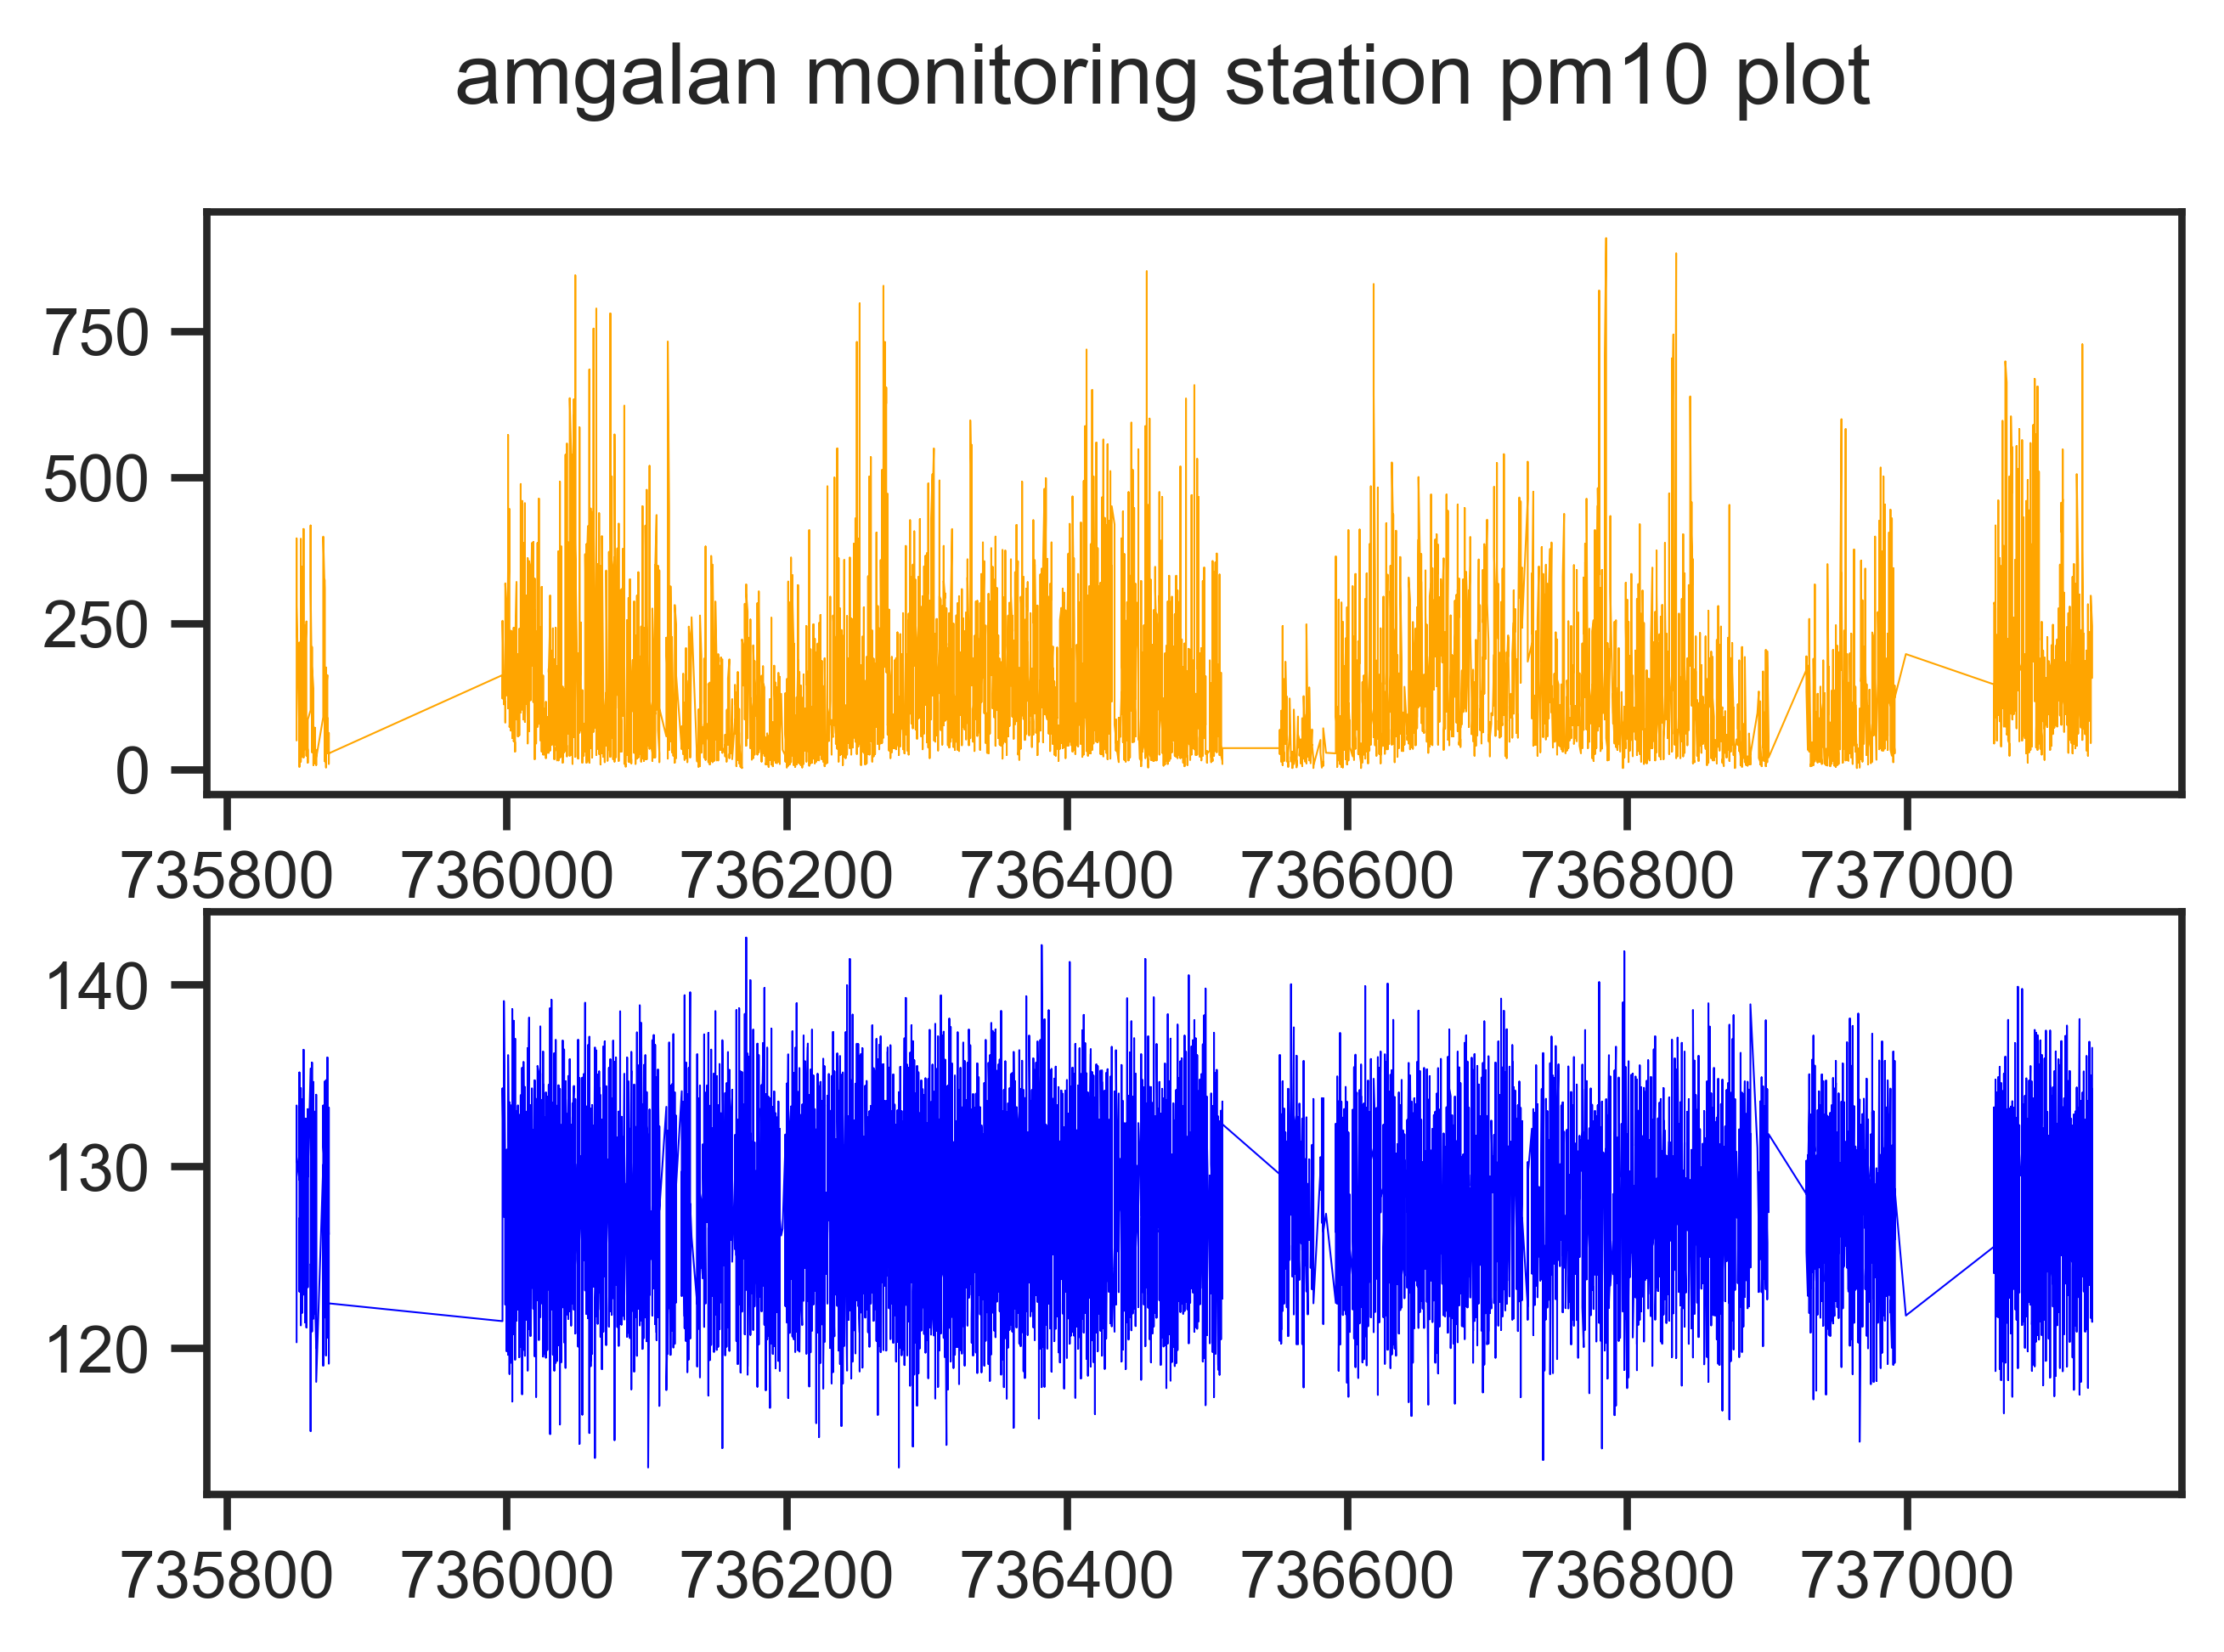

In [149]:
from datetime import datetime
amgalan_origin = pm10_df02[pm10_df02['location']=='Amgalan'][['date_time', 'location', 'value']]
amgalan_origin['julian'] = pd.DatetimeIndex(amgalan_origin['date_time']).to_julian_date()
amgalan_wn['julian'] = pd.DatetimeIndex(amgalan_wn['date']).to_julian_date()
amgalan_origin['ordinal_date'] = amgalan_origin['date_time'].apply(datetime.toordinal)
amgalan_wn['timestamp'] = pd.to_datetime(amgalan_wn.date, format="%Y-%m-%d %H:%M:%S")
amgalan_wn['ordinal_date'] = amgalan_wn['timestamp'].apply(datetime.toordinal)

amgalan_x1 = amgalan_origin.ordinal_date
amgalan_y1 = amgalan_origin.value
amgalan_x2 = amgalan_wn.ordinal_date
amgalan_y2 = amgalan_wn.value_predict

fig, axs = plt.subplots(2)
fig.suptitle('amgalan monitoring station pm10 plot')
axs[0].plot(amgalan_x1, amgalan_y1, color = 'orange', label = 'original data', linewidth=0.3)
axs[1].plot(amgalan_x2, amgalan_y2, color = 'blue', label = 'weather normalized data', linewidth=0.3)

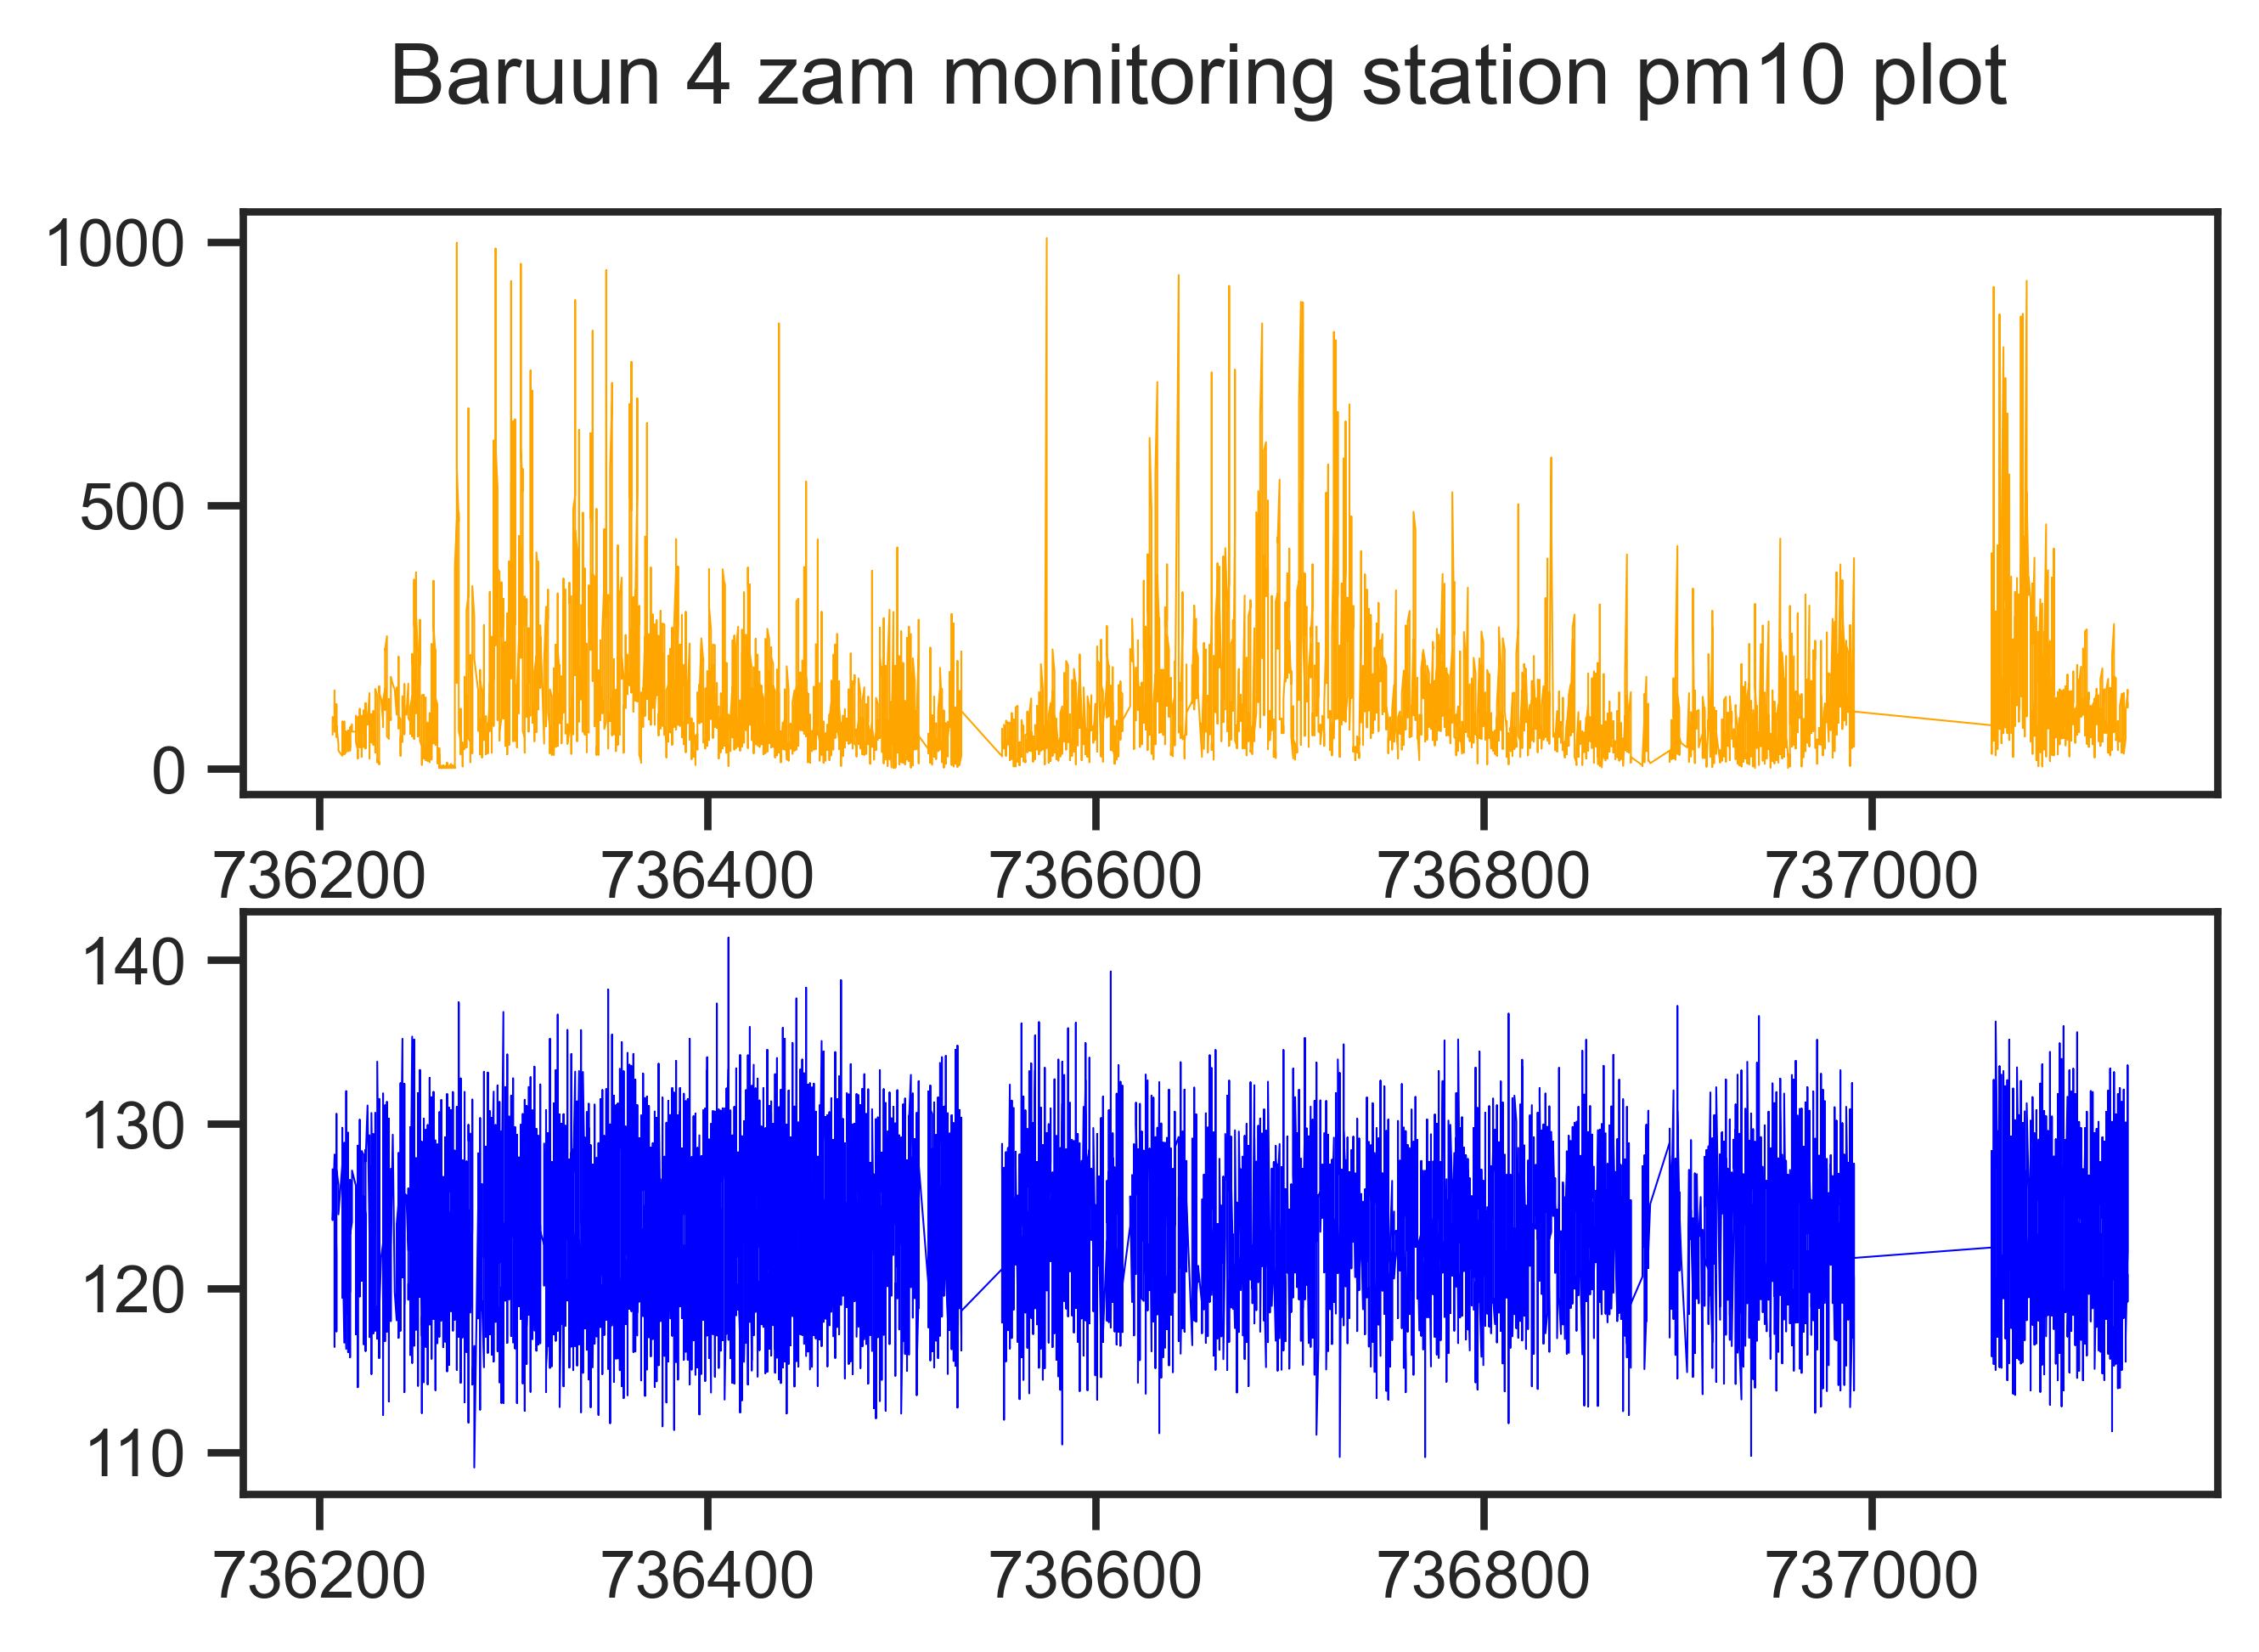

In [152]:
baruun_origin = pm10_df02[pm10_df02['location']=='Baruun 4 zam'][['date_time', 'location', 'value']]
baruun_origin['julian'] = pd.DatetimeIndex(baruun_origin['date_time']).to_julian_date()
baruun_wn['julian'] = pd.DatetimeIndex(baruun_wn['date']).to_julian_date()
baruun_origin['ordinal_date'] = baruun_origin['date_time'].apply(datetime.toordinal)
baruun_wn['timestamp'] = pd.to_datetime(baruun_wn.date, format="%Y-%m-%d %H:%M:%S")
baruun_wn['ordinal_date'] = baruun_wn['timestamp'].apply(datetime.toordinal)

baruun_x1 = baruun_origin.ordinal_date
baruun_y1 = baruun_origin.value
baruun_x2 = baruun_wn.ordinal_date
baruun_y2 = baruun_wn.value_predict

fig, axs = plt.subplots(2)
fig.suptitle('Baruun 4 zam monitoring station pm10 plot')
axs[0].plot(baruun_x1, baruun_y1, color = 'orange', label = 'original data', linewidth=0.3)
axs[1].plot(baruun_x2, baruun_y2, color = 'blue', label = 'weather normalized data', linewidth=0.3) 